In [194]:
from sklearn.datasets import make_regression, make_classification, make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import time
from GP_Classes import GaussianProcess, SparseGaussianProcess

In [195]:
def estimate_memory_usage(n_samples, n_features, model_type, n_inducing=None):
    # Memory for dataset (X_train and y_train)
    dataset_memory = n_samples * n_features * 8 + n_samples * 8  # X_train + y_train (float64, 8 bytes per float)
    if model_type == "GPR":
        # Full GP: Covariance matrix is N x N
        covariance_matrix_memory = n_samples ** 2 * 8  # N x N matrix, 8 bytes per float
    elif model_type == "SGPR":
        # Sparse GP: Covariance matrix is M x M (inducing points)
        if n_inducing is None:
            raise ValueError("n_inducing must be provided for SGPR")
        covariance_matrix_memory = n_inducing ** 2 * 8  # M x M matrix, 8 bytes per float
    
    # Memory for kernel parameters and gradients (assume around 1 KB for kernel + gradients)
    kernel_and_gradients_memory = 1024  # Rough estimation

    # Total memory usage estimate
    total_memory = dataset_memory + covariance_matrix_memory + kernel_and_gradients_memory

    return total_memory / (1024 ** 2)  # Convert to MB


In [196]:
# Function to train a GP model and return the RMSE, average uncertainty, time taken, and iteration count
def train_and_evaluate_gp(n_samples, model, optim_method):
    # Generate synthetic regression data
    X, y = make_regression(n_samples=n_samples, n_features=1, noise=1, random_state=0)  # n_features=1 for plotting
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Measure the time taken to optimize (which includes matrix inversion)
    start_time = time.time()
    
    # Optimize the model's parameters with a callback to count iterations
    if model == "GPR":
        model = GaussianProcess(X_train, y_train, optim_method)
    if model == "SGPR":
        n_inducing_points = int(len(X_train)*0.1)  # 10% of training points
        Z_train = X_train[np.random.choice(len(X_train), n_inducing_points, replace=False)]
        model = SparseGaussianProcess(X_train, y_train,Z_train, optim_method)
    
    noise = model.fit()
    
    
    end_time = time.time()
    
    # Time taken for matrix inversion and optimization
    time_taken = end_time - start_time
    
    # Retrieve and display parameter history if optimizer is ADAM
    if hasattr(model, "adam_optimizer"):
        param_history = model.adam_optimizer.param_history
        print("Parameter History:")
        #for params in param_history:

    
    # Make predictions on the test set
    means, variances = zip(*(model.predict(x.reshape(-1, 1)) for x in X_test))

    # Compute RMSE
    rmse = np.sqrt(np.mean((np.array(means) - y_test) ** 2))
    avg_uncertantiy = np.mean(np.sqrt(np.array(variances)))
    # Calculate the lower and upper bounds of the confidence interval
    lower_bound = means - 1.96 * np.sqrt(variances)
    upper_bound = means + 1.96 * np.sqrt(variances)
    # Check if y_test is within the confidence interval bounds
    uncertainties = np.where((lower_bound <= y_test) & (y_test <= upper_bound), 1, 0)
    in_interval = np.mean(uncertainties)

    return rmse, avg_uncertantiy, time_taken, noise, in_interval

In [197]:
import matplotlib.pyplot as plt
import numpy as np
import psutil
import time
import pandas as pd

# Utility to get memory usage
def get_memory_usage():
    process = psutil.Process()
    mem_info = process.memory_info()
    return mem_info.rss / (1024 ** 2)  # Return memory usage in MB

# General function to run comparison for multiple GP models
def run_comparison(max_samples, models_kernels):
    df = pd.DataFrame(columns=['Model', 'RMSE', 'Dataset Size', 'Time', 'Memory Usage', 'Avg Uncertainty', 'Predictive Noise', 'In Interval'])
    start = 100
    step = 50
    dataset_sizes = np.arange(start, max_samples + 1, step)

    # Dictionary to store results for each model
    results = {
        'loss_history': {},
        'times': {},
        'uncertainties': {},
        'memory_usages': {},
    }

    # Loop over each model and its kernel
    for model_name, optim_method in models_kernels:
        loss_history = []
        times = []
        uncertainties = []  
        memory_usages = []
        
        for idx, size in enumerate(dataset_sizes):
            rmse, avg_uncertantiy, time_taken, pred_noise, in_interval = train_and_evaluate_gp(size, model_name, optim_method)
            loss_history.append(rmse)
            memory = estimate_memory_usage(n_samples=size, n_features=1, model_type=model_name, n_inducing=0.1*size)
            uncertainties.append(avg_uncertantiy)
            times.append(time_taken)
            memory_usages.append(memory)
            name = model_name + " " + optim_method
            print(f"Model: {name}, Dataset size: {size}, Time: {time_taken:.4f} seconds, "
                  f"Memory: {memory:.2f} MB,"
                  f"Uncertainty: {avg_uncertantiy:.4f}")
            
            # Update dataframe
            new_row = pd.DataFrame({
                'Model': name,
                'Dataset Size': size,
                'RMSE': rmse,
                'Time': time_taken,
                'Memory Usage': memory,
                'Avg Uncertainty': avg_uncertantiy,
                'Predictive Noise': pred_noise,
                'In Interval': in_interval,
            }, index=[0])    

            df = pd.concat([df, new_row], ignore_index=True)
        
        # Store results for this model
        results['times'][name] = times
        results['uncertainties'][name] = uncertainties
        results['memory_usages'][name] = memory_usages
        results['loss_history'][name] = loss_history
    # Plotting the results

    print(df.head())
    df.to_csv('results.csv')
    plt.figure(figsize=(10, 12))
    # Loss plot

    plt.subplot(4, 1, 1)
    for name in results['loss_history']:
        plt.plot(dataset_sizes, results['loss_history'][name], 'o-', label=f'{name} Loss')
    plt.title('Performance Metrics vs Dataset Size')
    plt.ylabel('Loss (RMSE)')
    plt.xscale('log')
    plt.grid(True)
    plt.legend()
    
    # Time Plot
    plt.subplot(4, 1, 2)
    for name in results['times']:
        plt.plot(dataset_sizes, results['times'][name], 'o-', label=f'{name} Time')
    plt.title('Performance Metrics vs Dataset Size')
    plt.ylabel('Time (seconds)')
    plt.xscale('log')
    plt.grid(True)
    plt.legend()

    # Memory Usage Plot
    plt.subplot(4, 1, 3)
    for name in results['memory_usages']:
        plt.plot(dataset_sizes, results['memory_usages'][name], 'o-', label=f'{name} Memory Usage')
    plt.ylabel('Memory Usage (MB)')
    plt.xscale('log')
    plt.grid(True)
    plt.legend()

    # Uncertainty Plot
    plt.subplot(4, 1, 4)
    for name in results['uncertainties']:
        plt.plot(dataset_sizes, results['uncertainties'][name], 'o-', label=f'{name} Avg. Uncertainty')
    plt.ylabel('Uncertainty')
    plt.xscale('log')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    return results

NLL after optimization L-BFGS-B: 5872.9185
Model: GPR L-BFGS-B, Dataset size: 10, Time: 0.1681 seconds, Memory: 0.00 MB,Uncertainty: 0.0222


/var/folders/vk/1m8ycy4d2ysfq7vh0rdx92780000gn/T/ipykernel_18452/1863318754.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


NLL after optimization L-BFGS-B: 360.78003
Model: GPR L-BFGS-B, Dataset size: 20, Time: 0.5050 seconds, Memory: 0.00 MB,Uncertainty: 0.0188
Model: SGPR L-BFGS-B, Dataset size: 10, Time: 0.0496 seconds, Memory: 0.00 MB,Uncertainty: 1.0000
Model: SGPR L-BFGS-B, Dataset size: 20, Time: 0.1652 seconds, Memory: 0.00 MB,Uncertainty: 0.9991
NLL after optimization CG: 14942.79
Model: GPR CG, Dataset size: 10, Time: 0.1360 seconds, Memory: 0.00 MB,Uncertainty: 0.0221
NLL after optimization CG: 778.31726
Model: GPR CG, Dataset size: 20, Time: 1.3403 seconds, Memory: 0.00 MB,Uncertainty: 0.0267
Model: SGPR CG, Dataset size: 10, Time: 0.0324 seconds, Memory: 0.00 MB,Uncertainty: 1.0000
Model: SGPR CG, Dataset size: 20, Time: 0.1295 seconds, Memory: 0.00 MB,Uncertainty: 0.2015
Terminating on step size tolerance
Termination criterion met on iteration 0
NLL after optimization ADAM: 25336.494
Parameter History:
Model: GPR ADAM, Dataset size: 10, Time: 0.9119 seconds, Memory: 0.00 MB,Uncertainty: 0.094

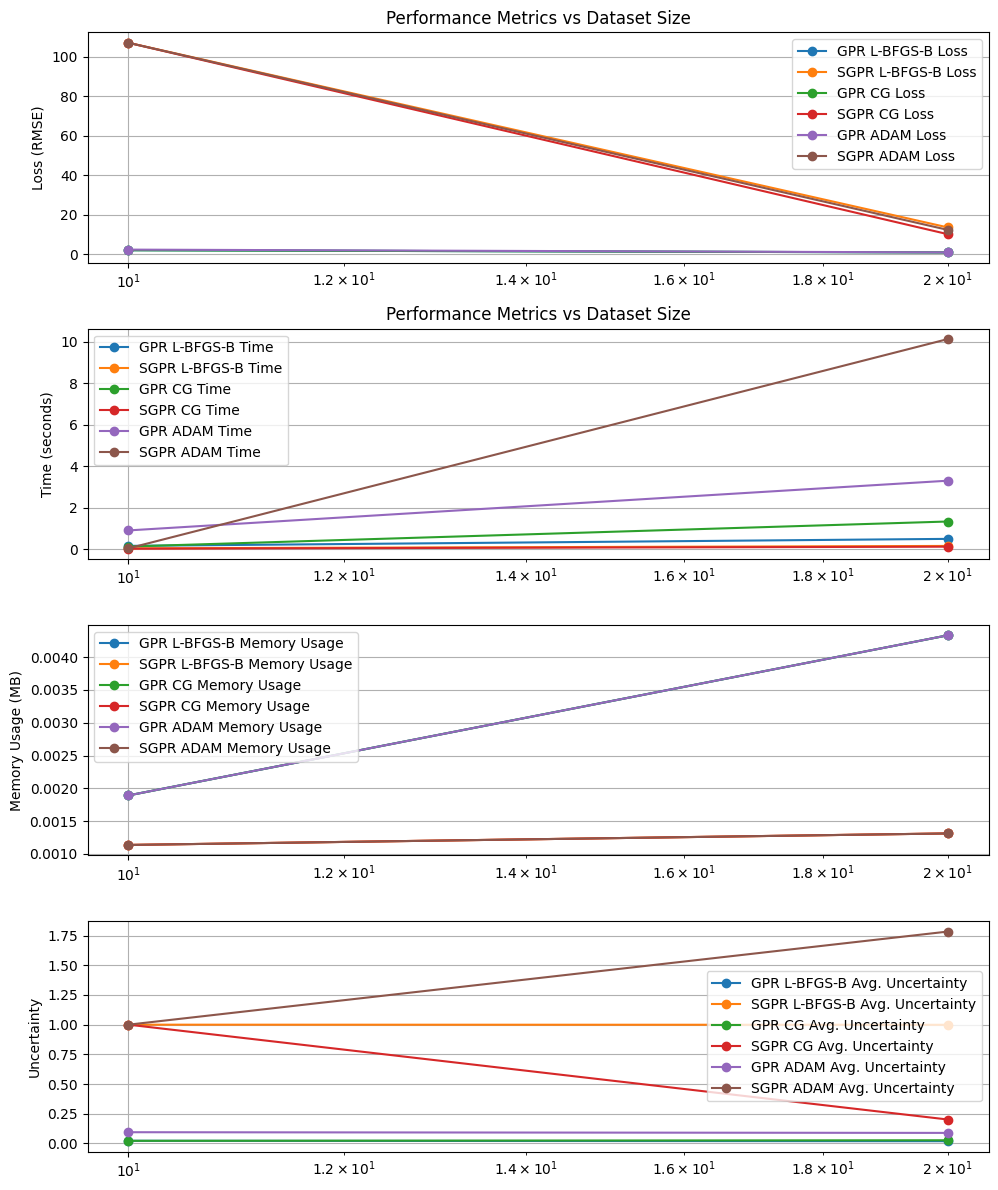

{'loss_history': {'GPR L-BFGS-B': [2.1254873660832794, 0.9960767928817809],
  'SGPR L-BFGS-B': [106.98157989221265, 13.650092252924217],
  'GPR CG': [2.1168752156509143, 0.9998055327352317],
  'SGPR CG': [106.98157989221265, 10.228043512562058],
  'GPR ADAM': [2.4276339174820443, 1.0194618629642778],
  'SGPR ADAM': [106.98157989221265, 12.399593203641627]},
 'times': {'GPR L-BFGS-B': [0.16806769371032715, 0.5049781799316406],
  'SGPR L-BFGS-B': [0.04960989952087402, 0.1651909351348877],
  'GPR CG': [0.135969877243042, 1.3403470516204834],
  'SGPR CG': [0.03239774703979492, 0.1295328140258789],
  'GPR ADAM': [0.9119091033935547, 3.3035190105438232],
  'SGPR ADAM': [0.050354957580566406, 10.117509126663208]},
 'uncertainties': {'GPR L-BFGS-B': [0.022170845, 0.018812608],
  'SGPR L-BFGS-B': [1.0000005, 0.9990966],
  'GPR CG': [0.0220825, 0.02673308],
  'SGPR CG': [1.0000005, 0.20145325],
  'GPR ADAM': [0.09446944, 0.088644266],
  'SGPR ADAM': [1.0000002, 1.7841182]},
 'memory_usages': {'G

In [198]:
models_kernels = [
    ("GPR", "L-BFGS-B"),
    ("SGPR", "L-BFGS-B"),
    ("GPR", "CG"),
    ("SGPR", "CG"),
    ("GPR", "ADAM"),
    ("SGPR", "ADAM"),
]
# Run the comparison for these models
run_comparison(max_samples=500, models_kernels=models_kernels)